In [1]:
import os
import laspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from matplotlib.colors import ListedColormap
from IPython.display import display  # For Jupyter display
import rasterio

In [2]:
def find_rgb_image(laz_data_path, dop_folder):
    file_identifier = os.path.basename(laz_data_path).split('.')[0].split('_')[-1]
    for root, _, files in os.walk(dop_folder):
        for file in files:
            if file_identifier in file and file.endswith('.tif'):
                return os.path.join(root, file)
    return None

def get_als_dop_matches(als_folder, dop_folder):
    matches = {}
    for root, _, files in os.walk(als_folder):
        for file in files:
            if file.endswith('.laz'):
                als_file_path = os.path.join(root, file)
                dop_image_path = find_rgb_image(als_file_path, dop_folder)
                if dop_image_path:
                    matches[als_file_path] = dop_image_path
    return matches




# Function to extract characteristics of LAS data
def extract_las_characteristics(file_path):
    """
    Extract characteristics such as point count, bounding box, intensity range, and classification counts.
    """
    las = laspy.read(file_path)
    
    # Extract basic information
    point_count = len(las.points)
    bounding_box = {
        "X_min": np.min(las.x),
        "X_max": np.max(las.x),
        "Y_min": np.min(las.y),
        "Y_max": np.max(las.y),
        "Z_min": np.min(las.z),
        "Z_max": np.max(las.z),
    }
    intensity_range = {
        "Intensity_min": np.min(las.intensity),
        "Intensity_max": np.max(las.intensity),
    }
    classification_counts = {
        "Classification": dict(zip(*np.unique(las.classification, return_counts=True)))
    }
    
    # Combine into a single dictionary
    characteristics = {
        "File": os.path.basename(file_path),
        "Point_Count": point_count,
        **bounding_box,
        **intensity_range,
        **classification_counts,
    }
    return characteristics



def check_invalid_coordinates(file_path):
    try:
        las = laspy.read(file_path)
        x_invalid = (las.header.mins[0] > las.x) | (las.header.maxs[0] < las.x)
        y_invalid = (las.header.mins[1] > las.y) | (las.header.maxs[1] < las.y)
        z_invalid = (las.header.mins[2] > las.z) | (las.header.maxs[2] < las.z)
        total_invalid = np.sum(x_invalid | y_invalid | z_invalid)
        total_points = len(las.points)
        return total_invalid, total_points
    except Exception as e:
        return 0, 0


def process_all_laz_files(laz_data_path_list):
    with ThreadPoolExecutor(max_workers=4) as executor:
        characteristics = list(executor.map(extract_las_characteristics, laz_data_path_list))
        coordinate_check_results = list(executor.map(check_invalid_coordinates, laz_data_path_list))
    
    df1 = pd.DataFrame(characteristics)
    df2 = pd.DataFrame([{
        "File": os.path.basename(file_path),
        "Invalid_Points": invalid,
        "Total_Points": total,
        "Percentage_Invalid": (invalid / total * 100) if total > 0 else 0
    } for (file_path, (invalid, total)) in zip(laz_data_path_list, coordinate_check_results)])
    
    return pd.merge(df1, df2, on="File", how="left")




In [ ]:
def visualize_features_per_file(file_paths, subsample_ratio=0.1):
    """
    Load LAZ files, subsample, and visualize features for each file.
    """
    for file_path in file_paths:
        print(f"Processing: {file_path}")
        las = laspy.read(file_path)
        num_points = len(las.x)
        sample_size = int(num_points * subsample_ratio)
        indices = np.random.choice(num_points, sample_size, replace=False)

        # Extract features
        points = np.vstack((las.x[indices], las.y[indices], las.z[indices])).T
        intensity = las.intensity[indices]
        classification = las.classification[indices]

        # Normalize height for visualization
        height = points[:, 2]
        normalized_height = (height - height.min()) / (height.max() - height.min())

        # Visualize histograms
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Intensity Histogram (Logarithmic)
        axes[0].hist(np.log1p(intensity), bins=50, color='blue', alpha=0.7)
        axes[0].set_title(f"Log-Scaled Intensity Histogram\n{file_path}")
        axes[0].set_xlabel("Log(Intensity)")
        axes[0].set_ylabel("Count")

        # Height Histogram
        axes[1].hist(height, bins=50, color='green', alpha=0.7)
        axes[1].set_title(f"Height Histogram\n{file_path}")
        axes[1].set_xlabel("Height")
        axes[1].set_ylabel("Count")

        # Classification Histogram
        axes[2].hist(classification, bins=np.arange(classification.min(), classification.max() + 2) - 0.5,
                     color='orange', alpha=0.7)
        axes[2].set_title(f"Classification Histogram\n{file_path}")
        axes[2].set_xlabel("Class ID")
        axes[2].set_ylabel("Count")

        plt.tight_layout()
        plt.show()

In [4]:
base_dir = "data/Tschernitz/als"
dop_folder = "data/Tschernitz/dop"

# Match ALS and DOP files
als_dop_matches = get_als_dop_matches(base_dir, dop_folder)
laz_data_path_list = list(als_dop_matches.keys())

# Process LAS files and get a summary
results_df = process_all_laz_files(laz_data_path_list)

results_df

,File,Point_Count,X_min,X_max,Y_min,Y_max,Z_min,Z_max,Intensity_min,Intensity_max,Classification,Invalid_Points,Total_Points,Percentage_Invalid
0,als_33470-5714.laz,22062075,470000.001,470999.999,5714000.001,5714999.999,130.020,171.391,5,65534,"{0: 6978087, 1: 25201, 2: 11779121, 20: 3279666}",0,22062075,0.0
1,als_33470-5715.laz,22538896,470000.001,470999.999,5715000.001,5715999.999,130.839,170.605,5,65534,"{0: 8220544, 1: 482, 2: 10298993, 20: 4018877}",0,22538896,0.0
2,als_33470-5716.laz,24346342,470000.001,470999.999,5716000.001,5716999.999,130.429,178.734,5,65534,"{0: 8656768, 1: 12051, 2: 11727369, 20: 3950154}",0,24346342,0.0


Processing: data/Tschernitz/als\als_33470-5714\als_33470-5714.laz


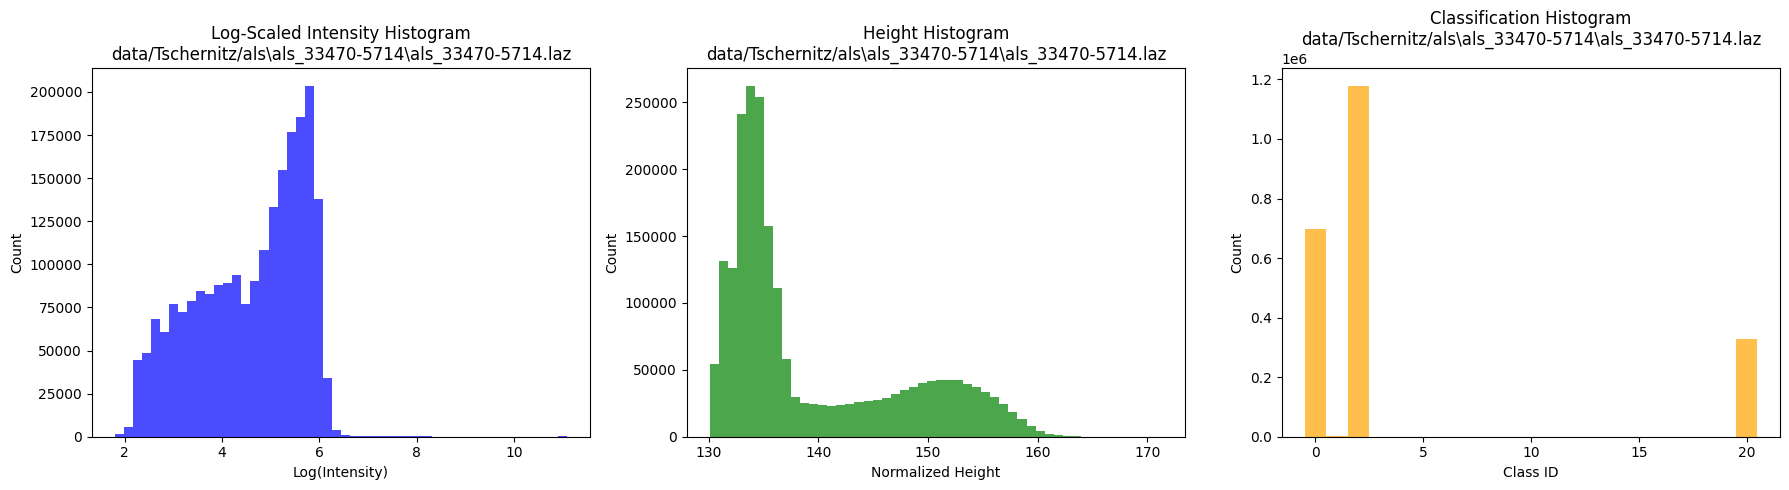

Processing: data/Tschernitz/als\als_33470-5715\als_33470-5715.laz


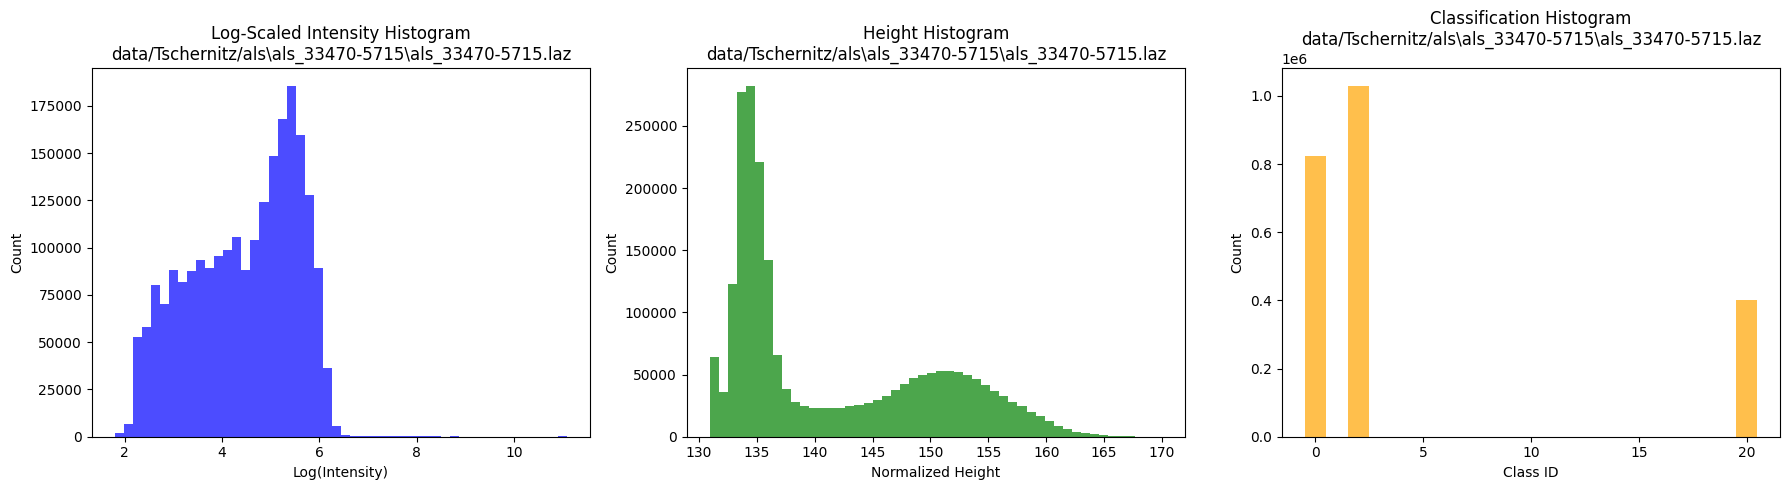

Processing: data/Tschernitz/als\als_33470-5716\als_33470-5716.laz


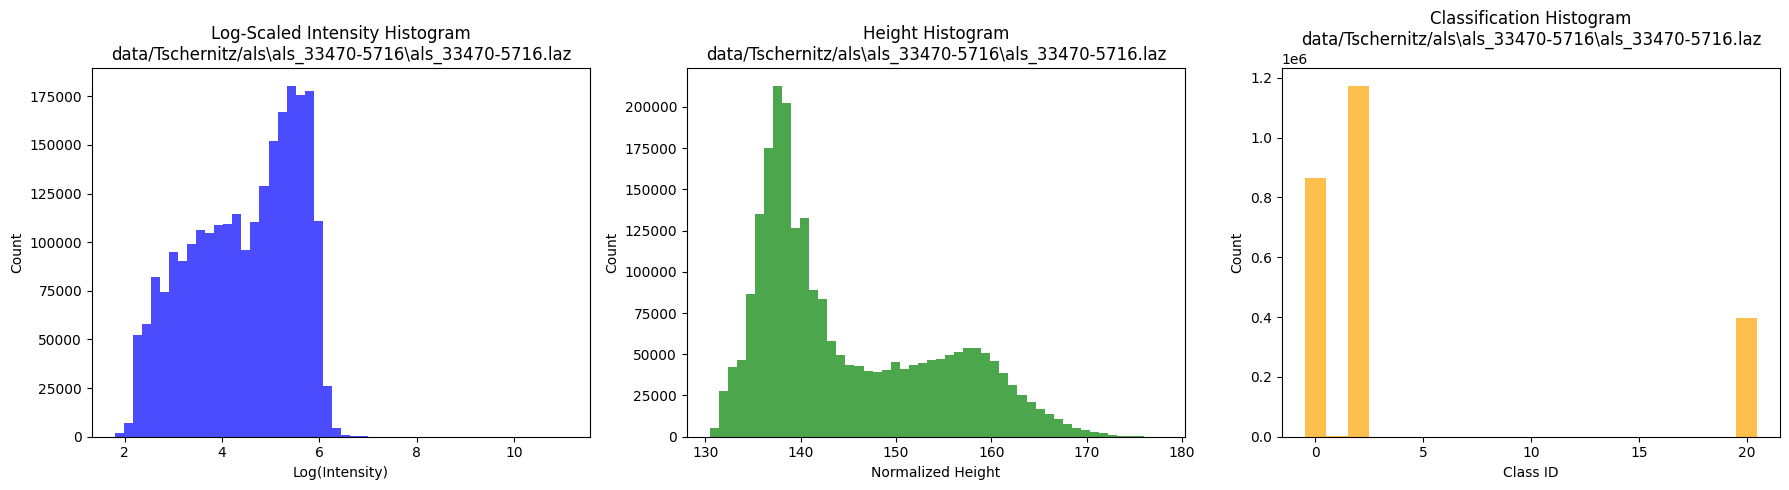

In [10]:
# Visualize features for each LAZ file
visualize_features_per_file(laz_data_path_list, subsample_ratio=0.1)

In [7]:
def filter_and_visualize_by_height(file_paths, subsample_ratio=0.1, bins=[3, 4], num_bins=10):
    """
    Load LAZ files, filter points by normalized height bins, and visualize their spatial distribution.
    
    Parameters:
        file_paths (list): List of LAZ file paths.
        subsample_ratio (float): Ratio of points to subsample from each file.
        bins (list): Bins to include in the visualization.
        num_bins (int): Total number of bins for height distribution.
    """
    for file_path in file_paths:
        print(f"Processing: {file_path}")
        las = laspy.read(file_path)
        num_points = len(las.x)
        sample_size = int(num_points * subsample_ratio)
        indices = np.random.choice(num_points, sample_size, replace=False)

        # Extract features
        points = np.vstack((las.x[indices], las.y[indices], las.z[indices])).T
        height = points[:, 2]

        # Normalize height
        normalized_height = (height - height.min()) / (height.max() - height.min())

        # Bin heights
        height_bins = np.linspace(0, 1, num_bins + 1)
        bin_indices = np.digitize(normalized_height, bins=height_bins) - 1

        # Filter points in the specified bins
        selected_bins = np.isin(bin_indices, bins)
        filtered_points = points[selected_bins]

        # Visualize the filtered points
        if filtered_points.shape[0] > 0:
            plt.figure(figsize=(8, 6))
            plt.scatter(filtered_points[:, 0], filtered_points[:, 1], s=1, alpha=0.5, c=filtered_points[:, 2], cmap='viridis')
            plt.colorbar(label="Height (Z)")
            plt.title(f"Spatial Distribution of Points in Bins {bins}\n{file_path}")
            plt.xlabel("X Coordinate")
            plt.ylabel("Y Coordinate")
            plt.axis("equal")
            plt.show()
        else:
            print(f"No points found in bins {bins} for file {file_path}.")


Processing: data/Tschernitz/als\als_33470-5714\als_33470-5714.laz


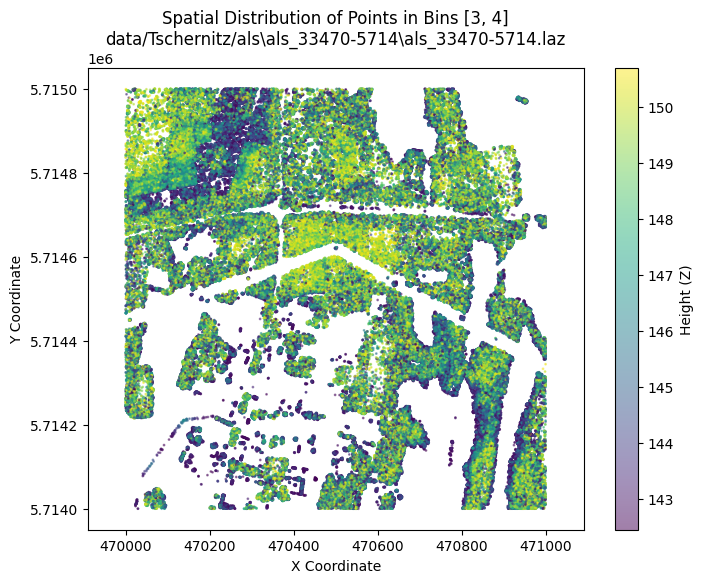

Processing: data/Tschernitz/als\als_33470-5715\als_33470-5715.laz


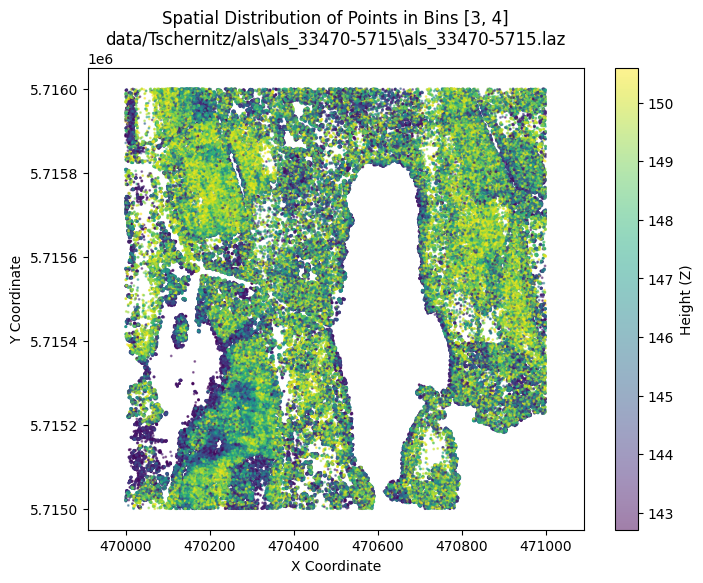

Processing: data/Tschernitz/als\als_33470-5716\als_33470-5716.laz


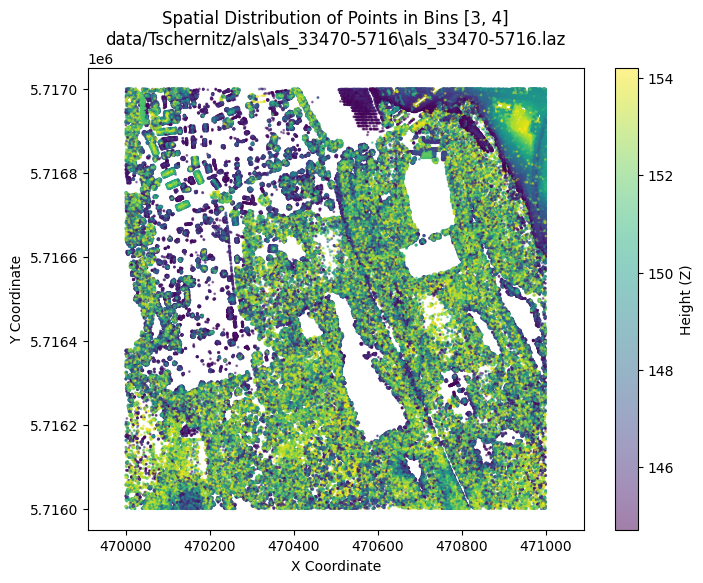

In [8]:
# Filter and visualize points in bins 3 and 4
filter_and_visualize_by_height(laz_data_path_list, subsample_ratio=0.1)

In [ ]:
def filter_and_visualize_binned_height(data, num_bins=None, exclude_bins=None):
    """
    Filter and visualize binned LiDAR height data in a 2D scatter plot with distinct colors for each bin.
    If `num_bins` is None, height data is treated as continuous and not binned.

    Parameters:
        data (dict): LiDAR data containing 'points' key with Nx3 array of x, y, z coordinates.
        num_bins (int or None): Number of bins to divide the height data into. If None, use continuous height values.
        exclude_bins (list or None): List of bins to exclude from the data.

    Returns:
        dict: Filtered LiDAR data with all keys updated.
    """
    points = data['points']
    x, y, z = points[:, 0], points[:, 1], points[:, 2]

    if num_bins is not None:
        # Bin the height (z) data
        bins = np.linspace(np.min(z), np.max(z), num_bins + 1)
        bin_indices = np.digitize(z, bins, right=True)

        # Filter out excluded bins
        if exclude_bins:
            mask = ~np.isin(bin_indices, exclude_bins)
            filtered_data = {key: value[mask] for key, value in data.items()}
    else:
        # No binning, use continuous height values
        mask = np.ones(len(points), dtype=bool)  # Keep all data
        filtered_data = {key: value[mask] for key, value in data.items()}

    # Visualization
    if num_bins is not None:
        plt.figure(figsize=(10, 8))
        for i in range(1, len(bins)):
            bin_mask = bin_indices == i
            if np.any(bin_mask):  # Check if any points exist in this bin
                plt.scatter(x[bin_mask], y[bin_mask], s=1, label=f'Bin {i} ({bins[i-1]:.2f} - {bins[i]:.2f})')

        plt.title("Filtered and Binned LiDAR Height (Z)")
        plt.legend(markerscale=10, title="Height Bins")
    else:
        # Continuous height
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(x, y, c=z, cmap='viridis', s=1)
        plt.colorbar(scatter, label="Height (Z)")
        plt.title("Filtered LiDAR Height (Z)")

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.tight_layout()
    plt.show()

    return filtered_data


In [ ]:
def scale_and_overlay_lidar_on_rgb(rgb_image_path, lidar_data, num_bins=None, alpha=0.5):
    """
    Scale filtered LiDAR data to match the extent of the RGB image and overlay it with a high-contrast colormap.

    Parameters:
        rgb_image_path (str): Path to the RGB image file.
        lidar_data (dict): Filtered LiDAR data containing points and features.
        num_bins (int or None): Number of bins to colorize the height data. If None, uses continuous height values.
        alpha (float): Opacity level for the LiDAR overlay (0 to 1).
    """
    # Load the RGB image and its metadata
    with rasterio.open(rgb_image_path) as src:
        rgb_image = src.read([1, 2, 3]).transpose((1, 2, 0)) / 255.0
        rgb_extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

    # Extract LiDAR points
    points = lidar_data['points']
    x, y, z = points[:, 0], points[:, 1], points[:, 2]

    # Scale LiDAR coordinates to match the RGB extent
    x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x)) * (rgb_extent[1] - rgb_extent[0]) + rgb_extent[0]
    y_scaled = (y - np.min(y)) / (np.max(y) - np.min(y)) * (rgb_extent[3] - rgb_extent[2]) + rgb_extent[2]

    # Handle height visualization
    if num_bins is not None:
        # Bin the height data
        bins = np.linspace(np.min(z), np.max(z), num_bins + 1)
        bin_indices = np.digitize(z, bins, right=True)

        # Define a high-contrast colormap
        high_contrast_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231']
        cmap = ListedColormap(high_contrast_colors[:num_bins])

        # Create the scatter plot
        plt.figure(figsize=(10, 8))
        plt.imshow(rgb_image, extent=rgb_extent, origin='upper', alpha=0.7)  # Background image opacity
        scatter = plt.scatter(x_scaled, y_scaled, c=bin_indices, cmap=cmap, s=1, alpha=alpha)  # LiDAR mask opacity

        # Add legend for bins
        legend_labels = [f'Bin {i} ({bins[i-1]:.2f} - {bins[i]:.2f})' for i in range(1, len(bins))]
        handles = [plt.Line2D([0], [0], marker='o', color=cmap(i / (num_bins - 1)), linestyle='None', markersize=8) 
                   for i in range(num_bins)]
        plt.legend(handles, legend_labels, title="Height Bins", loc="upper right", markerscale=1.5)
    else:
        # Use continuous height data
        plt.figure(figsize=(10, 8))
        plt.imshow(rgb_image, extent=rgb_extent, origin='upper', alpha=0.7)  # Background image opacity
        scatter = plt.scatter(x_scaled, y_scaled, c=z, cmap="viridis", s=1, alpha=alpha)  # Continuous height

    plt.title("Filtered LiDAR Data Overlayed on RGB (Aligned and Scaled)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.tight_layout()
    plt.show()


In [ ]:
def visualize_classification_masks(data):
    """
    Visualize all unique classification classes in the LiDAR data one by one as individual masks.

    Parameters:
        data (dict): LiDAR data containing points and classification feature.
    """
    points = data['points']
    x, y = points[:, 0], points[:, 1]
    classification = data['classification']

    # Get unique classification values
    unique_classes = np.unique(classification)

    for cls in unique_classes:
        # Mask for the current classification
        mask = classification == cls
        x_cls = x[mask]
        y_cls = y[mask]

        # Create scatter plot for the current class
        plt.figure(figsize=(10, 8))
        plt.scatter(x_cls, y_cls, color='blue', s=1, label=f'Class {cls}')
        plt.title(f"LiDAR Classification Mask for Class {cls}")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()